In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Gold_CRC_BA = pd.read_csv("SingaporeCRC_data/genus_strictfilted_clr.csv", index_col=0,delimiter=",")
Gold_CRC_BA = Gold_CRC_BA.T

pid = Gold_CRC_BA.index #.astype('float')
Gold_CRC_BA.insert(0,'patient_id',pid)

Gold_CRC_BA

,patient_id,g__Paraburkholderia,g__Lautropia,g__Roseateles,g__Aquincola,g__Piscinibacter,g__Sphaerotilus,g__Caldimonas,g__Rubrivivax,g__Methylibium,...,g__Ligilactobacillus,g__Megamonas,g__Gottschalkia,g__Berryella,g__Capsulimonas,g__Gemmobacter,g__Thermovirga,g__Treponema,g__Terrisporobacter,g__Allobaculum
X47,X47,-0.131743,-0.642569,4.045716,1.785179,1.814167,1.031408,0.823768,1.203258,0.897876,...,-0.354887,-1.048034,-1.741181,-1.741181,-1.741181,0.456043,-1.741181,0.050578,-1.741181,-1.741181
X95,X95,-2.122681,1.343055,1.731006,-0.547145,-0.918708,-1.024069,-1.516545,-1.275383,-1.968530,...,1.154464,3.170624,-3.221293,-1.024069,-2.305003,-3.914441,-3.221293,-2.815828,-0.153240,1.075992
X106,X106,-1.102375,-0.090774,2.804636,0.912528,0.344544,-0.186084,-0.409227,-0.291444,-0.409227,...,-0.090774,-1.390057,0.730207,-1.795522,-0.003762,-0.879231,4.426062,-1.390057,-2.488669,-0.696910
X153,X153,-1.102788,-0.815106,3.205771,1.295107,1.017475,0.688971,-0.121959,0.196495,-0.815106,...,0.196495,-0.815106,-2.201401,-1.102788,-2.201401,-0.409641,-1.508253,-2.201401,-2.201401,-0.815106
X326,X326,-1.704407,-1.704407,2.406466,-0.094969,0.167395,0.000341,-0.094969,-0.451644,-0.200330,...,-1.704407,6.623198,-2.397555,-2.397555,-2.397555,-1.704407,-2.397555,-2.397555,-1.298942,-2.397555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1662,X1662,-3.295067,-2.447769,0.675225,-1.560466,-1.828730,-2.091094,-2.447769,-3.007385,-2.784241,...,2.077120,4.710078,-0.522478,-1.828730,-0.404695,-3.007385,-2.784241,-3.295067,-2.601920,2.349202
X1664,X1664,-1.271815,-1.271815,3.732131,1.772708,1.618557,1.030770,-0.173203,0.114480,-0.173203,...,-1.271815,0.337623,-0.173203,-1.271815,-1.271815,-0.578668,-1.271815,-1.271815,-1.271815,-1.271815
X1665,X1665,-1.983832,-1.983832,3.169460,1.194222,0.906540,0.724218,0.788757,-0.192072,0.095610,...,-1.290685,-0.885219,-0.885219,-1.983832,-1.983832,-0.597537,-1.983832,-1.290685,-1.290685,-1.983832
X1672,X1672,-2.445815,-2.445815,2.924823,0.921480,1.080545,0.850021,-0.836377,-0.654056,0.039091,...,-1.752668,4.274405,-2.445815,-2.445815,-2.445815,-2.445815,-2.445815,-1.752668,-2.445815,-0.836377


In [3]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,SMAD4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,wt,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,mut,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [4]:
metadata.columns

Index(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'],
      dtype='object')

In [5]:
SG_Gold_CRC_BA = pd.merge(Gold_CRC_BA, metadata, on='patient_id', how='inner')
SG_Gold_CRC_BA
#SG_Gold_CRC_BA.to_csv('SingaporeCRC_data/SG_Gold_CRC_BA', index=False)

In [56]:
class_counts = SG_Gold_CRC_BA['iCMS'].value_counts()
print(class_counts)

iCMS
iCMS2    61
iCMS3    50
Name: count, dtype: int64


In [57]:
# Prepare features and target variable
X = SG_Gold_CRC_BA.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_Gold_CRC_BA['iCMS']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['iCMS2' 'iCMS3']
Unique values of y: [0 1]
Shape of y: (111, 208)
Shape of y: (111,)


In [58]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)


(122, 208)
(122,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
Best Score: 0.7176470588235294
Test Set Accuracy: 0.5135135135135135


<Figure size 800x600 with 0 Axes>

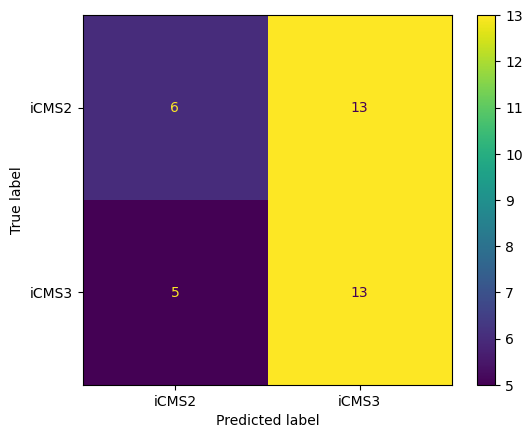

              precision    recall  f1-score   support

       iCMS2       0.55      0.32      0.40        19
       iCMS3       0.50      0.72      0.59        18

    accuracy                           0.51        37
   macro avg       0.52      0.52      0.50        37
weighted avg       0.52      0.51      0.49        37



In [59]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['iCMS2', 'iCMS3'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['iCMS2', 'iCMS3'])
print(report)

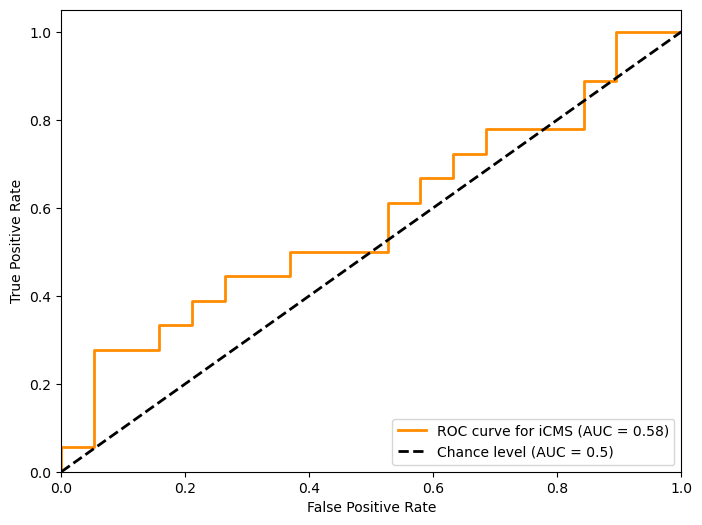

In [60]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for iCMS (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_18720\2900214027.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


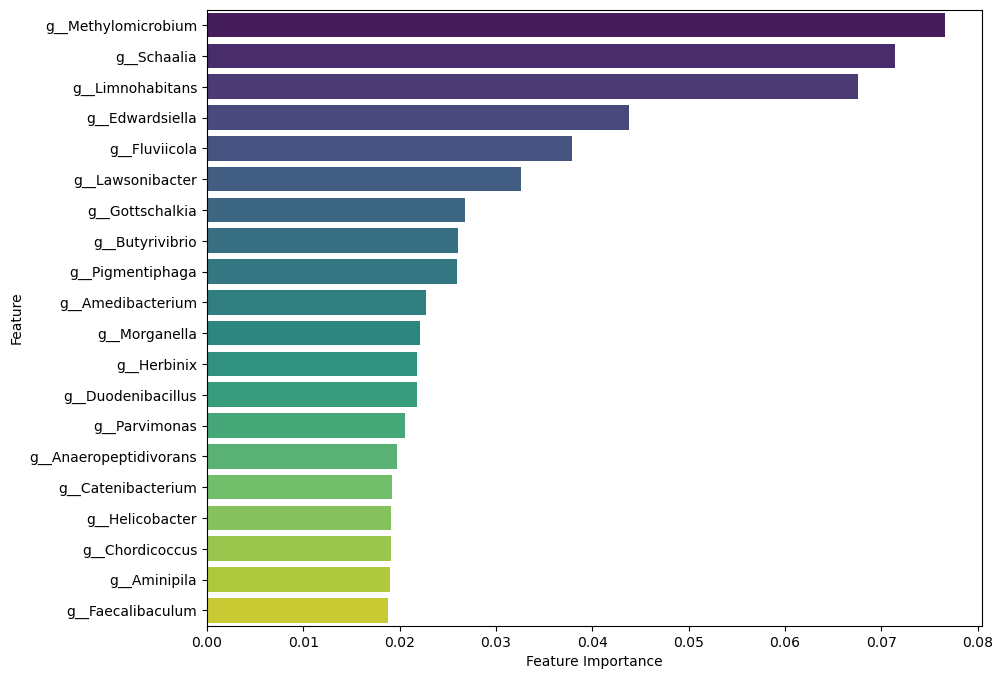

In [61]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

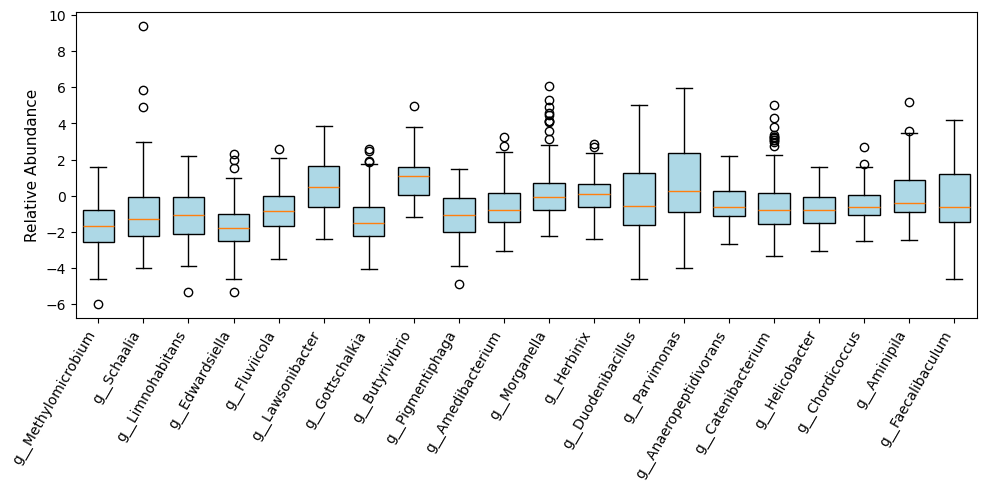

In [65]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_20_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

#plt.ylim(-10, 15)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()